<a href="https://colab.research.google.com/github/Flash3241/Account-Creator/blob/main/assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import gzip
from collections import defaultdict

def readGz(path):
  for l in gzip.open(path, 'rt'):
    yield eval(l)

def readCSV(filename, skip_header=True):
    with gzip.open(filename, 'rt', encoding='utf-8') as f:
        first_line = True
        for line in f:
            if skip_header and first_line:
                first_line = False
                continue
            yield line.strip().split(',')


In [ ]:
# DATASET: TWITCH
# User ID (anonymized)
# Stream ID
# Streamer username
# Time start
# Time stop
# Example: 1,34347669376,grimnax,5415,5419

# Data structures for statistics
user_to_streams = defaultdict(set)  # Maps user ID to the streams they watched
stream_to_duration = defaultdict(int)  # Maps stream ID to total duration
total_duration = 0  # Sum of all stream durations
total_interactions = 0  # Total interactions
data = []  # Collect processed data for the model

# Load data from the .gz file
for user_id, stream_id, streamer, start_time, stop_time in readCSV("100k_a.csv.gz"):
    user_id = int(user_id)
    start_time = int(start_time)
    stop_time = int(stop_time)
    duration = stop_time - start_time  # Calculate duration of stream interaction

    # Update statistics
    total_duration += duration
    total_interactions += 1
    user_to_streams[user_id].add(stream_id)
    stream_to_duration[stream_id] += duration

    # Append processed data
    data.append({
        "user_id": user_id,
        "stream_id": stream_id,
        "streamer": streamer,
        "start_time": start_time,
        "stop_time": stop_time,
        "duration": duration
    })

# Display statistics
print(f"Total duration of streams: {total_duration} (10-minute units)")
print(f"Total interactions: {total_interactions}")
print(f"Number of unique users: {len(user_to_streams)}")
print(f"Number of unique streams: {len(stream_to_duration)}")

# Example: Get the most watched stream
most_watched_stream = max(stream_to_duration.items(), key=lambda x: x[1])
print(f"Most watched stream ID: {most_watched_stream[0]}, Duration: {most_watched_stream[1]}")


Total duration of streams: 9588709 (10-minute units)
Total interactions: 3051732
Number of unique users: 100000
Number of unique streams: 739991
Most watched stream ID: 34057836560, Duration: 11327


In [ ]:
# TASK: Predict the Duration of Engagement with a Stream
'''
Description: Predict how long a user will spend on a stream (e.g., stop_time - start_time).
Features:
- User interaction history (number of streams watched, average duration).
- Streamer popularity.
- Time of day and day of the week.
- Duration of the previous session with the same streamer.

Evaluation:
- Metric: Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).
- Approach: Train regression models (e.g., Linear Regression, Random Forest, or Neural Networks).

Baselines:
- Predict the mean session duration across all users.
- Predict the median session duration per streamer.

Validity Assessment:
- Perform residual analysis to check for systematic biases.
- Cross-validation to ensure stability across folds.

Citation
Please cite the following if you use the data:

Recommendation on Live-Streaming Platforms: Dynamic Availability and Repeat Consumption
Jérémie Rappaz, Julian McAuley and Karl Aberer
RecSys, 2021

https://cseweb.ucsd.edu/~jmcauley/datasets.html#twitch
'''

'\nDescription: Predict how long a user will spend on a stream (e.g., stop_time - start_time).\nFeatures:\n- User interaction history (number of streams watched, average duration).\n- Streamer popularity.\n- Time of day and day of the week.\n- Duration of the previous session with the same streamer.\n\nEvaluation:\n- Metric: Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE).\n- Approach: Train regression models (e.g., Linear Regression, Random Forest, or Neural Networks).\n\nBaselines:\n- Predict the mean session duration across all users.\n- Predict the median session duration per streamer.\n\nValidity Assessment:\n- Perform residual analysis to check for systematic biases.\n- Cross-validation to ensure stability across folds.\n\nCitation\nPlease cite the following if you use the data:\n\nRecommendation on Live-Streaming Platforms: Dynamic Availability and Repeat Consumption\nJérémie Rappaz, Julian McAuley and Karl Aberer\nRecSys, 2021\n\nhttps://cseweb.ucsd.edu/~jmcauley/da

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Step 1: Prepare data
# Assuming `data` is the processed list of dictionaries from previous steps
df = pd.DataFrame(data[:100000])  # Use 100,000 rows for testing
#df = pd.DataFrame(data)


# Calculate engagement duration (target variable)
df['engagement_duration'] = df['stop_time'] - df['start_time']

# Calculate streamer popularity (total watch time for each streamer)
streamer_popularity = df.groupby('streamer')['engagement_duration'].sum().rename('total_watch_time')
df = df.merge(streamer_popularity, on='streamer', how='left')
print(f"1")
# User interaction history: Number of streams watched, average duration
user_stats = df.groupby('user_id').agg(
    num_streams_watched=('stream_id', 'count'),
    avg_duration=('engagement_duration', 'mean')
).reset_index()
df = df.merge(user_stats, on='user_id', how='left')

# Time of day and day of the week
df['start_time'] = pd.to_datetime(df['start_time'])
df['hour_of_day'] = df['start_time'].dt.hour
df['day_of_week'] = df['start_time'].dt.dayofweek
print(f"2")
# Previous session duration
df['prev_session_duration'] = df.groupby('user_id')['engagement_duration'].shift(1).fillna(0)

# Step 2: Prepare features and target
features = [
    'total_watch_time', 'num_streams_watched', 'avg_duration',
    'hour_of_day', 'day_of_week', 'prev_session_duration'
]
X = df[features]
y = df['engagement_duration']

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Step 4: Train the regression model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)
print(f"3")
# Step 5: Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Baseline comparisons
baseline_mean = np.mean(y_train)
baseline_median = np.median(y_train)
print(f"Baseline Mean Engagement Duration (MAE): {mean_absolute_error(y_test, [baseline_mean] * len(y_test)):.2f}")
print(f"Baseline Median Engagement Duration (MAE): {mean_absolute_error(y_test, [baseline_median] * len(y_test)):.2f}")


1
2
3
Evaluation Results:
Mean Absolute Error (MAE): 2.17
Root Mean Squared Error (RMSE): 3.82
Baseline Mean Engagement Duration (MAE): 2.46
Baseline Median Engagement Duration (MAE): 2.04


In [ ]:
# Types of Models to POTENTIALLY USE (we need to use some from class for baseline apparently)
'''
1. Gradient Boosting Models (e.g., XGBoost, LightGBM, CatBoost)
Why They're Accurate:
These models iteratively improve predictions by correcting errors from previous iterations, leading to highly precise results.
They handle nonlinear relationships and feature interactions effectively.
Feature importance scores allow interpretability and fine-tuning.
Use Case for Duration Prediction:
Handles a mix of numerical (e.g., session duration, streamer popularity) and categorical (e.g., user ID, time of day) features well.
Works with missing or sparse data.
Optimization:
Tune hyperparameters like the learning rate, number of trees, and tree depth using grid search or Bayesian optimization.
Use early stopping to prevent overfitting.
Potential Drawbacks:
Requires careful tuning for optimal performance.
Can be computationally intensive on large datasets.

2. Deep Neural Networks (DNNs)
Why They're Accurate:
Neural networks can learn complex, nonlinear patterns in data and capture intricate feature interactions.
Flexible architecture allows integration of diverse feature types, such as embeddings for categorical variables (e.g., user ID, streamer).
Use Case for Duration Prediction:
Suitable for large datasets where patterns are highly nonlinear or there are many interactions between features.
Optimization:
Use dropout and batch normalization to mitigate overfitting.
Employ early stopping and learning rate decay during training.
Regularize the model using L1/L2 penalties to prevent overfitting on noisy features.
Potential Drawbacks:
Requires large amounts of data for training to avoid overfitting.
Less interpretable compared to tree-based models.

3. Random Forest Regressor
Why They're Accurate:
Ensemble model that averages predictions from multiple decision trees, reducing variance and improving generalization.
Works well with small to medium-sized datasets and is less prone to overfitting than individual decision trees.
Use Case for Duration Prediction:
Robust to outliers and irrelevant features, making it suitable for noisy data.
Provides interpretable feature importance for analysis.
Optimization:
Tune the number of trees, tree depth, and minimum samples per split using random or grid search.
Increase the number of trees for more stable predictions.
Potential Drawbacks:
Can struggle with very large datasets or extremely high-dimensional feature spaces.
Slower inference compared to Gradient Boosting.

4. Support Vector Regressor (SVR) with Kernel Trick
Why They're Accurate:
SVR with kernels (e.g., RBF, polynomial) captures nonlinear relationships between features and the target variable.
Provides excellent performance on smaller datasets where high precision is required.
Use Case for Duration Prediction:
Works well when the dataset has a moderate number of samples and complex relationships that are hard to capture linearly.
Optimization:
Tune hyperparameters like kernel type, regularization parameter (C), and epsilon (tolerance margin).
Use grid search or random search for hyperparameter tuning.
Potential Drawbacks:
Computationally expensive on large datasets due to reliance on pairwise computations.
Requires feature scaling (e.g., normalization) for optimal performance.

5. Transformers for Tabular Data (TabNet, TabTransformer)
Why They're Accurate:
Transformers for tabular data excel at learning feature interactions and hierarchical patterns using attention mechanisms.
Can encode sequential features like past interactions efficiently.
Use Case for Duration Prediction:
Useful for datasets with both categorical and numerical features, capturing relationships between them without extensive preprocessing.
Optimization:
Use early stopping and warm-up learning rates for efficient training.
Fine-tune hyperparameters like number of attention heads, depth, and embedding sizes.
Potential Drawbacks:
High computational cost compared to tree-based models.
Requires significant tuning and expertise to implement effectively.
'''

"\n1. Gradient Boosting Models (e.g., XGBoost, LightGBM, CatBoost)\nWhy They're Accurate:\nThese models iteratively improve predictions by correcting errors from previous iterations, leading to highly precise results.\nThey handle nonlinear relationships and feature interactions effectively.\nFeature importance scores allow interpretability and fine-tuning.\nUse Case for Duration Prediction:\nHandles a mix of numerical (e.g., session duration, streamer popularity) and categorical (e.g., user ID, time of day) features well.\nWorks with missing or sparse data.\nOptimization:\nTune hyperparameters like the learning rate, number of trees, and tree depth using grid search or Bayesian optimization.\nUse early stopping to prevent overfitting.\nPotential Drawbacks:\nRequires careful tuning for optimal performance.\nCan be computationally intensive on large datasets.\n\n2. Deep Neural Networks (DNNs)\nWhy They're Accurate:\nNeural networks can learn complex, nonlinear patterns in data and captu

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Evaluation Results:
Mean Absolute Error (MAE): 2.08
Root Mean Squared Error (RMSE): 3.54
Baseline Mean Engagement Duration (MAE): 2.40
Baseline Median Engagement Duration (MAE): 1.96


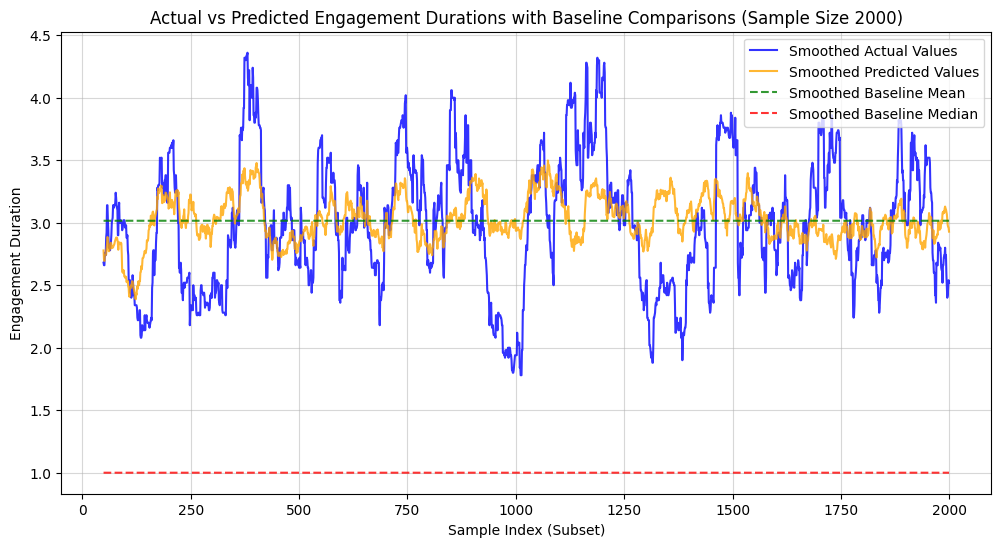

In [ ]:
# RANDOM FOREST REGRESSION MODEL
import gzip
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Optimized RandomForestRegressor model
model = RandomForestRegressor(
    random_state=42,
    n_estimators=100,   # Reduced number of trees
    max_depth=10,       # Limit tree depth to a smaller number
    max_features='log2', # Use logarithmic number of features for each split
    n_jobs=-1,           # Use all available CPU cores
    warm_start=True      # Enable warm start for incremental fitting
)

# Fit the model with reduced training time
model.fit(X_train, y_train)

# GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [100, 200],  # Reduce the range of trees for faster search
    'max_depth': [5, 15],        # Limited depth for faster tuning
    'max_features': ['log2', 'sqrt'],  # Test log2 and sqrt for feature splits
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1, warm_start=True),
    param_grid,
    cv=3,  # Reduced cross-validation folds for faster tuning
    n_jobs=-1,  # Parallelize the fitting
    verbose=2
)

# Fit the model using GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Step 5: Evaluate the model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Baseline comparisons
baseline_mean = np.mean(y_train)
baseline_median = np.median(y_train)
print(f"Baseline Mean Engagement Duration (MAE): {mean_absolute_error(y_test, [baseline_mean] * len(y_test)):.2f}")
print(f"Baseline Median Engagement Duration (MAE): {mean_absolute_error(y_test, [baseline_median] * len(y_test)):.2f}")

# Step 6: Actual vs Predicted plot with smoothing
# Convert test and predicted data to Pandas Series
actual_values = pd.Series(y_test.reset_index(drop=True))
predicted_values = pd.Series(y_pred)
baseline_mean_line = pd.Series([baseline_mean] * len(y_test))
baseline_median_line = pd.Series([baseline_median] * len(y_test))

# Sample a subset of 2000 points for visualization
sample_size = 2000
actual_values = actual_values[:sample_size]
predicted_values = predicted_values[:sample_size]
baseline_mean_line = baseline_mean_line[:sample_size]
baseline_median_line = baseline_median_line[:sample_size]

# Smooth the lines by calculating rolling averages
window_size = 50  # Window size for smoothing
smoothed_actual = actual_values.rolling(window=window_size).mean()
smoothed_predicted = predicted_values.rolling(window=window_size).mean()
smoothed_baseline_mean = baseline_mean_line.rolling(window=window_size).mean()
smoothed_baseline_median = baseline_median_line.rolling(window=window_size).mean()

# Plot the smoothed line graph
plt.figure(figsize=(12, 6))
plt.plot(smoothed_actual, label='Smoothed Actual Values', color='blue', alpha=0.8)
plt.plot(smoothed_predicted, label='Smoothed Predicted Values', color='orange', alpha=0.8)
plt.plot(smoothed_baseline_mean, label='Smoothed Baseline Mean', color='green', linestyle='dashed', alpha=0.8)
plt.plot(smoothed_baseline_median, label='Smoothed Baseline Median', color='red', linestyle='dashed', alpha=0.8)

# Add labels, title, and legend
plt.title('Actual vs Predicted Engagement Durations with Baseline Comparisons (Sample Size 2000)')
plt.xlabel('Sample Index (Subset)')
plt.ylabel('Engagement Duration')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

In [ ]:
# MODEL 2 For RANDOM FOREST REGRESSION
import gzip
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint

# Assuming you have preprocessed data X and y (features and target variable)
# You can modify this section to use your actual dataset
# X = your_features_dataframe
# y = your_target_variable

# Step 1: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: RandomizedSearchCV for Hyperparameter Tuning
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
}

# Create and fit the RandomizedSearchCV
random_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=50,  # Number of random configurations to try
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit the random search model
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Step 3: Evaluate the model using the best model from RandomizedSearchCV
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Baseline comparisons
baseline_mean = np.mean(y_train)
baseline_median = np.median(y_train)
print(f"Baseline Mean Engagement Duration (MAE): {mean_absolute_error(y_test, [baseline_mean] * len(y_test)):.2f}")
print(f"Baseline Median Engagement Duration (MAE): {mean_absolute_error(y_test, [baseline_median] * len(y_test)):.2f}")

# Step 4: Residuals Plot (Model Diagnostics)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.5)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='red', linestyles='dashed')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Actual Values')
plt.show()

# Step 5: Learning Curves
train_sizes, train_scores, valid_scores = learning_curve(
    RandomForestRegressor(random_state=42), X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Error')
plt.plot(train_sizes, np.mean(valid_scores, axis=1), label='Validation Error')
plt.xlabel('Training Set Size')
plt.ylabel('Error')
plt.legend()
plt.title('Learning Curves')
plt.show()

# Optional: Save the best model if needed
import joblib
joblib.dump(best_model, 'best_random_forest_model.pkl')


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


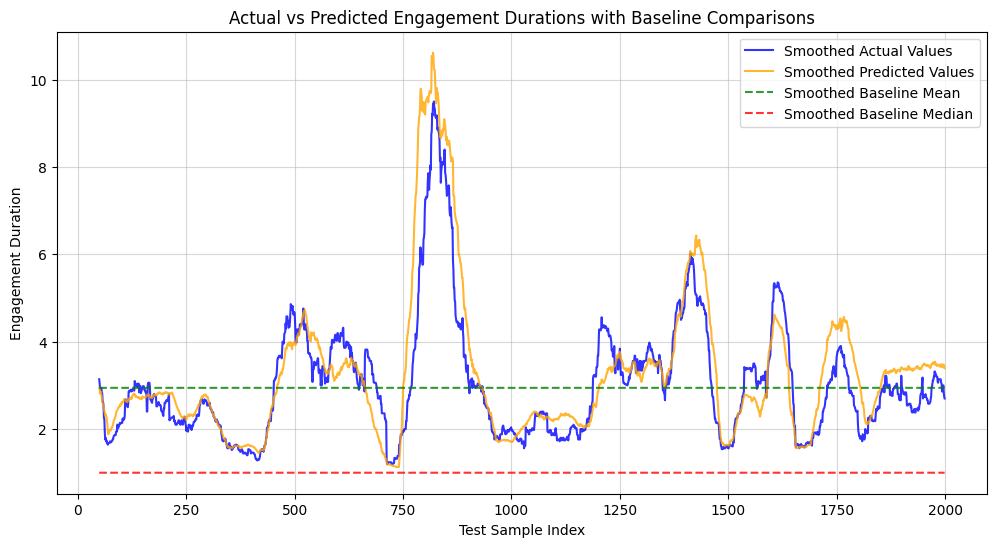

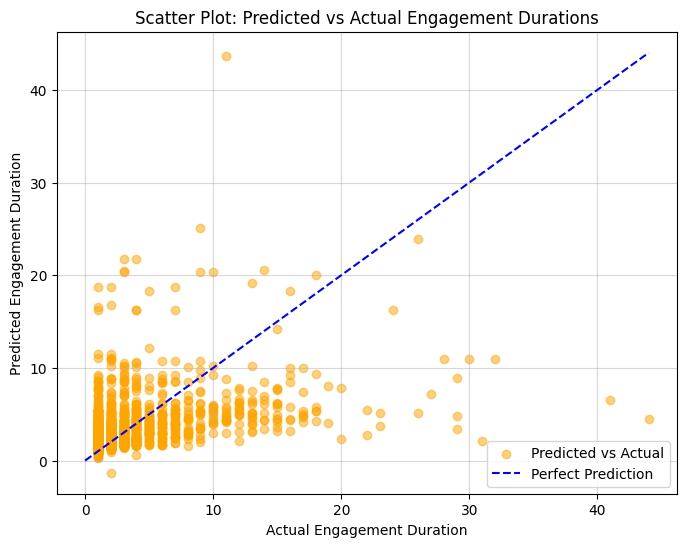

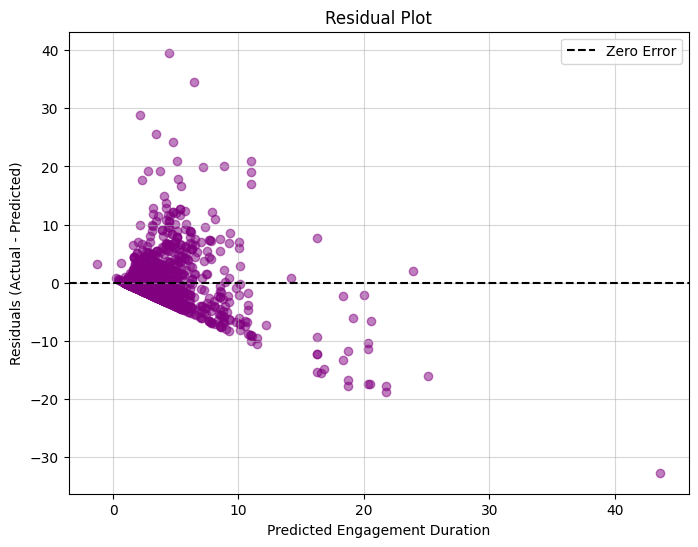

Model Evaluation Results:
                                      Metric     Value
0                  Mean Absolute Error (MAE)  2.127551
1             Root Mean Squared Error (RMSE)  3.829349
2    Baseline Mean Engagement Duration (MAE)  2.401798
3  Baseline Median Engagement Duration (MAE)  2.056500


In [ ]:
#GRADIENT BOOSTING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Step 1: Data Preparation (already processed data is assumed)
df = pd.DataFrame(data[:10000])  # Use the first 10,000 rows

# Calculate engagement duration (target variable)
df['engagement_duration'] = df['stop_time'] - df['start_time']

# Calculate streamer popularity (total watch time for each streamer)
streamer_popularity = df.groupby('streamer')['engagement_duration'].sum().rename('total_watch_time')
df = df.merge(streamer_popularity, on='streamer', how='left')

# User interaction history: Number of streams watched, average duration
user_stats = df.groupby('user_id').agg(
    num_streams_watched=('stream_id', 'count'),
    avg_duration=('engagement_duration', 'mean')
).reset_index()
df = df.merge(user_stats, on='user_id', how='left')

# Time of day and day of the week
df['start_time'] = pd.to_datetime(df['start_time'])
df['hour_of_day'] = df['start_time'].dt.hour
df['day_of_week'] = df['start_time'].dt.dayofweek

# Previous session duration
df['prev_session_duration'] = df.groupby('user_id')['engagement_duration'].shift(1).fillna(0)

# Prepare features and target
features = [
    'total_watch_time', 'num_streams_watched', 'avg_duration',
    'hour_of_day', 'day_of_week', 'prev_session_duration'
]
X = df[features]
y = df['engagement_duration']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Step 2: Train the Gradient Boosting Model
gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Baseline Calculations
baseline_mean = np.mean(y_train)
baseline_median = np.median(y_train)
mean_mae = mean_absolute_error(y_test, [baseline_mean] * len(y_test))
median_mae = mean_absolute_error(y_test, [baseline_median] * len(y_test))

# Step 3: Line Graph Comparison
# Smooth the lines by calculating rolling averages
actual_values = pd.Series(y_test.reset_index(drop=True))
predicted_values = pd.Series(y_pred)
baseline_mean_line = pd.Series([baseline_mean] * len(y_test))
baseline_median_line = pd.Series([baseline_median] * len(y_test))

window_size = 50  # Smoothing window
smoothed_actual = actual_values.rolling(window=window_size).mean()
smoothed_predicted = predicted_values.rolling(window=window_size).mean()
smoothed_baseline_mean = baseline_mean_line.rolling(window=window_size).mean()
smoothed_baseline_median = baseline_median_line.rolling(window=window_size).mean()

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(smoothed_actual, label='Smoothed Actual Values', color='blue', alpha=0.8)
plt.plot(smoothed_predicted, label='Smoothed Predicted Values', color='orange', alpha=0.8)
plt.plot(smoothed_baseline_mean, label='Smoothed Baseline Mean', color='green', linestyle='dashed', alpha=0.8)
plt.plot(smoothed_baseline_median, label='Smoothed Baseline Median', color='red', linestyle='dashed', alpha=0.8)
plt.title('Actual vs Predicted Engagement Durations with Baseline Comparisons')
plt.xlabel('Test Sample Index')
plt.ylabel('Engagement Duration')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='orange', label='Predicted vs Actual')
plt.plot([0, max(y_test)], [0, max(y_test)], color='blue', linestyle='--', label='Perfect Prediction')
plt.title('Scatter Plot: Predicted vs Actual Engagement Durations')
plt.xlabel('Actual Engagement Duration')
plt.ylabel('Predicted Engagement Duration')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(y=0, color='black', linestyle='--', label='Zero Error')
plt.title('Residual Plot')
plt.xlabel('Predicted Engagement Duration')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Step 4: Evaluation Results Table
results_df = pd.DataFrame({
    "Metric": [
        "Mean Absolute Error (MAE)",
        "Root Mean Squared Error (RMSE)",
        "Baseline Mean Engagement Duration (MAE)",
        "Baseline Median Engagement Duration (MAE)"
    ],
    "Value": [mae, rmse, mean_mae, median_mae]
})

print("Model Evaluation Results:")
print(results_df)


In [ ]:
# HARD MODEL FOR GRADIENT BOOSTING
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Step 1: Data Preparation (already processed data is assumed)
df = pd.DataFrame(data[:10000])  # Use the first 10,000 rows

# Calculate engagement duration (target variable)
df['engagement_duration'] = df['stop_time'] - df['start_time']

# Calculate streamer popularity (total watch time for each streamer)
streamer_popularity = df.groupby('streamer')['engagement_duration'].sum().rename('total_watch_time')
df = df.merge(streamer_popularity, on='streamer', how='left')

# User interaction history: Number of streams watched, average duration
user_stats = df.groupby('user_id').agg(
    num_streams_watched=('stream_id', 'count'),
    avg_duration=('engagement_duration', 'mean')
).reset_index()
df = df.merge(user_stats, on='user_id', how='left')

# Time of day and day of the week
df['start_time'] = pd.to_datetime(df['start_time'])
df['hour_of_day'] = df['start_time'].dt.hour
df['day_of_week'] = df['start_time'].dt.dayofweek

# Previous session duration
df['prev_session_duration'] = df.groupby('user_id')['engagement_duration'].shift(1).fillna(0)

# Prepare features and target
features = [
    'total_watch_time', 'num_streams_watched', 'avg_duration',
    'hour_of_day', 'day_of_week', 'prev_session_duration'
]
X = df[features]
y = df['engagement_duration']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Step 2: Train the Gradient Boosting Model
gbr = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
gbr.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = gbr.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Baseline Calculations
baseline_mean = np.mean(y_train)
baseline_median = np.median(y_train)
mean_mae = mean_absolute_error(y_test, [baseline_mean] * len(y_test))
median_mae = mean_absolute_error(y_test, [baseline_median] * len(y_test))

# Step 3: Line Graph Comparison
# Smooth the lines by calculating rolling averages
actual_values = pd.Series(y_test.reset_index(drop=True))
predicted_values = pd.Series(y_pred)
baseline_mean_line = pd.Series([baseline_mean] * len(y_test))
baseline_median_line = pd.Series([baseline_median] * len(y_test))

window_size = 50  # Smoothing window
smoothed_actual = actual_values.rolling(window=window_size).mean()
smoothed_predicted = predicted_values.rolling(window=window_size).mean()
smoothed_baseline_mean = baseline_mean_line.rolling(window=window_size).mean()
smoothed_baseline_median = baseline_median_line.rolling(window=window_size).mean()

# Plot the line graph
plt.figure(figsize=(12, 6))
plt.plot(smoothed_actual, label='Smoothed Actual Values', color='blue', alpha=0.8)
plt.plot(smoothed_predicted, label='Smoothed Predicted Values', color='orange', alpha=0.8)
plt.plot(smoothed_baseline_mean, label='Smoothed Baseline Mean', color='green', linestyle='dashed', alpha=0.8)
plt.plot(smoothed_baseline_median, label='Smoothed Baseline Median', color='red', linestyle='dashed', alpha=0.8)
plt.title('Actual vs Predicted Engagement Durations with Baseline Comparisons')
plt.xlabel('Test Sample Index')
plt.ylabel('Engagement Duration')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

# Step 4: Evaluation Results Table
results_df = pd.DataFrame({
    "Metric": [
        "Mean Absolute Error (MAE)",
        "Root Mean Squared Error (RMSE)",
        "Baseline Mean Engagement Duration (MAE)",
        "Baseline Median Engagement Duration (MAE)"
    ],
    "Value": [mae, rmse, mean_mae, median_mae]
})

print("Model Evaluation Results:")
print(results_df)


NameError: name 'data' is not defined

In [ ]:
# # MODEL USING NEURAL NETWORKS
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
# from tensorflow.keras.regularizers import l1_l2
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import mean_absolute_error, mean_squared_error # Add this import statement



# df = pd.DataFrame(data[:100000])
# df

# # 1. User Interaction History
# user_history = df.groupby('user_id').agg(
#     streams_watched=('stream_id', 'count'),
#     avg_duration=('duration', 'mean')
# ).reset_index()

# # Merge user history back into the main DataFrame
# df = df.merge(user_history, on='user_id', how='left')

# # 2. Streamer Popularity
# streamer_popularity = df['streamer'].value_counts().reset_index()
# streamer_popularity.columns = ['streamer', 'popularity']

# # Merge streamer popularity into the main DataFrame
# df = df.merge(streamer_popularity, on='streamer', how='left')

# # 3. Time of Day and Day of the Week
# # Assuming `start_time` is in seconds from a known timestamp
# df['start_time_hours'] = (df['start_time'] % 86400) // 3600  # Convert to hours
# df['time_of_day'] = pd.cut(
#     df['start_time_hours'],
#     bins=[0, 6, 12, 18, 24],
#     labels=['Night', 'Morning', 'Afternoon', 'Evening'],
#     right=False
# )

# # For day of the week, assuming `start_time` is Unix-like seconds
# df['day_of_week'] = ((df['start_time'] // 86400) % 7).map(
#     {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
# )

# # 4. Duration of the Previous Session with the Same Streamer
# df['prev_session_duration'] = df.groupby(['user_id', 'streamer'])['duration'].shift(1)

# # Fill NaN for the first session with each streamer
# df['prev_session_duration'].fillna(0, inplace=True)


# # 1. Prepare the data
# # Assuming `df` contains the features and target
# X = df[['streams_watched', 'avg_duration', 'popularity', 'time_of_day', 'day_of_week', 'prev_session_duration']]
# y = df['duration']

# # Categorical and numerical features
# categorical_features = ['time_of_day', 'day_of_week']
# numerical_features = ['streams_watched', 'avg_duration', 'popularity', 'prev_session_duration']

# # Preprocessing pipeline
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', MinMaxScaler(), numerical_features),
#         ('cat', OneHotEncoder(), categorical_features)
#     ]
# )

# # Apply preprocessing to the data
# X_preprocessed = preprocessor.fit_transform(X)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# # 2. Define the neural network
# model = Sequential([
#     Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
#     BatchNormalization(),  # Batch normalization for better convergence
#     Dropout(0.3),  # Dropout to prevent overfitting
#     Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
#     BatchNormalization(),
#     Dropout(0.3),
#     Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
#     Dense(1)  # Output layer for regression
# ])

# # Compile the model
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#               loss='mse',
#               metrics=['mae'])

# # 3. Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# # 4. Train the model
# history = model.fit(
#     X_train, y_train,
#     validation_split=0.2,
#     epochs=100,
#     batch_size=32,
#     callbacks=[early_stopping, lr_decay],
#     verbose=1
# )

# # 5. Evaluate the model
# loss, mae = model.evaluate(X_test, y_test, verbose=1)
# print(f"Test Loss: {loss:.4f}, Test MAE: {mae:.4f}")


# baseline_mean = np.mean(y_train)
# baseline_median = np.median(y_train)
# print(f"Baseline Mean Engagement Duration (MAE): {mean_absolute_error(y_test, [baseline_mean] * len(y_test)):.2f}")
# print(f"Baseline Median Engagement Duration (MAE): {mean_absolute_error(y_test, [baseline_median] * len(y_test)):.2f}")


# # 6. Make predictions
# y_pred = model.predict(X_test)

# # Plot predicted vs actual values
# plt.scatter(y_test, y_pred)
# plt.xlabel("Actual Values")
# plt.ylabel("Predicted Values")
# plt.title("Logistic Regression: Predicted vs Actual")
# plt.show()


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd

# Assuming `data` contains the dataset
df = pd.DataFrame(data[:100000])

# Feature Engineering
# 1. User Interaction History
user_history = df.groupby('user_id').agg(
    streams_watched=('stream_id', 'count'),
    avg_duration=('duration', 'mean')
).reset_index()

df = df.merge(user_history, on='user_id', how='left')

# 2. Streamer Popularity
streamer_popularity = df['streamer'].value_counts().reset_index()
streamer_popularity.columns = ['streamer', 'popularity']

df = df.merge(streamer_popularity, on='streamer', how='left')

# 3. Time of Day and Day of the Week
df['start_time_hours'] = (df['start_time'] % 86400) // 3600  # Convert to hours
df['time_of_day'] = pd.cut(
    df['start_time_hours'],
    bins=[0, 6, 12, 18, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    right=False
)

df['day_of_week'] = ((df['start_time'] // 86400) % 7).map(
    {0: 'Sunday', 1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday'}
)

# 4. Duration of the Previous Session with the Same Streamer
df['prev_session_duration'] = df.groupby(['user_id', 'streamer'])['duration'].shift(1)
df['prev_session_duration'].fillna(0, inplace=True)

# Features and Target
X = df[['streams_watched', 'avg_duration', 'popularity', 'time_of_day', 'day_of_week', 'prev_session_duration']]
y = df['duration']

# Preprocessing
categorical_features = ['time_of_day', 'day_of_week']
numerical_features = ['streams_watched', 'avg_duration', 'popularity', 'prev_session_duration']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

X_preprocessed = preprocessor.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Neural Network Definition
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),
    Dense(1)  # Output layer for regression
])

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=['mae', 'mse'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_decay = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Model Training
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, lr_decay],
    verbose=1
)

# Model Evaluation
loss, mae, mse = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {loss:.4f}, Test MAE: {mae:.4f}, Test MSE: {mse:.4f}")

# Baseline Metrics
baseline_mean = np.mean(y_train)
baseline_median = np.median(y_train)
print(f"Baseline Mean Engagement Duration (MSE): {mean_squared_error(y_test, [baseline_mean] * len(y_test)):.2f}")
print(f"Baseline Median Engagement Duration (MSE): {mean_squared_error(y_test, [baseline_median] * len(y_test)):.2f}")

# Predictions
y_pred = model.predict(X_test)

# Plot Predicted vs. Actual Values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Engagement Duration")
plt.show()

